 Starting Solar PV Fault Detection
 Dataset already prepared. Skipping data prep.
 Loading image data...
Found 694 images belonging to 2 classes.
Found 175 images belonging to 2 classes.
 Building and training model...


C:\Users\HP\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\HP\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.7041 - loss: 1.4772 - val_accuracy: 0.8114 - val_loss: 0.4002
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.7883 - loss: 0.4538 - val_accuracy: 0.8057 - val_loss: 0.3858
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.7589 - loss: 0.4747 - val_accuracy: 0.8057 - val_loss: 0.4316
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.8095 - loss: 0.4195 - val_accuracy: 0.6514 - val_loss: 0.5369
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.7896 - loss: 0.4362 - val_accuracy: 0.8286 - val_loss: 0.3765
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.8149 - loss: 0.3893 - val_accuracy: 0.7714 - val_loss: 0.4562
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.8105 - loss: 0.4024 - val_accuracy: 0.8343 - val_loss: 0.3836
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.8110 - loss: 0.4107 - val_accuracy: 0.8343 - val_loss:

Model saved as solar_fault_classifier.h5
 Running predictions on random mixed (Clean + Defect) images...


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
Dust (21).jpg: Defect (0.8799999952316284)


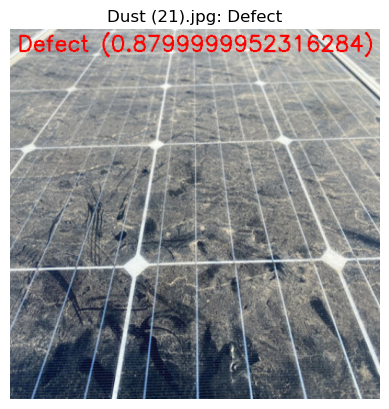

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Dust (139).jpg: Clean (0.33000001311302185)


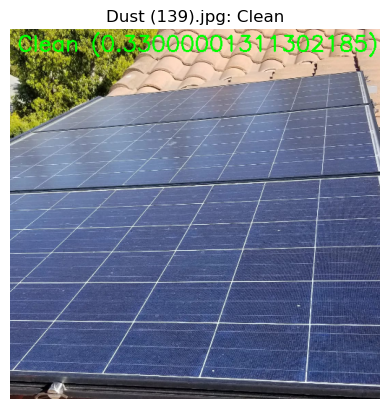

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Bird (171).JPG: Defect (0.9599999785423279)


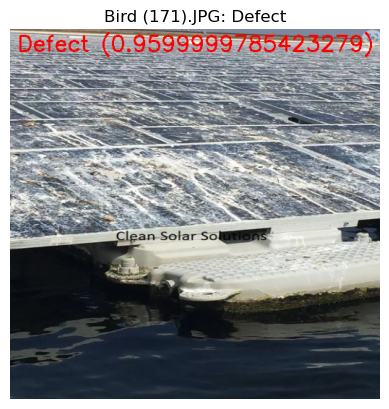

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Bird (116).jpg: Clean (0.25)


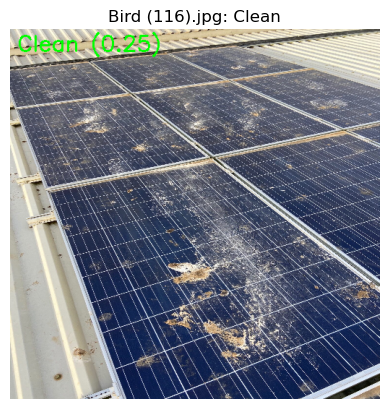

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Snow (57).jpg: Defect (0.8299999833106995)


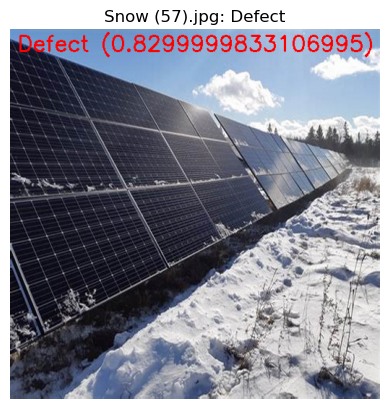

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Electrical (1).jpg: Clean (0.3100000023841858)


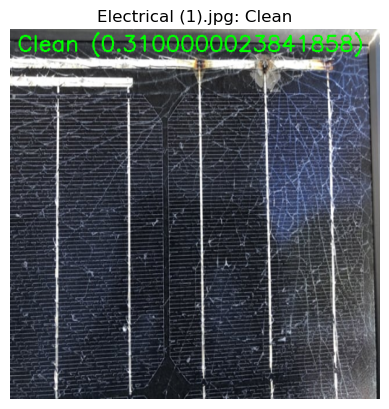

In [1]:
import os
import shutil
import random
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split

# --- CONFIGURATION ---
ORIGINAL_DATASET_DIR = 'SolarPV_Images'
BASE_DIR = 'Processed_Dataset'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VAL_DIR = os.path.join(BASE_DIR, 'val')
CLEAN_DIR = os.path.join(ORIGINAL_DATASET_DIR, 'Clean')
FAULT_CLASSES = ['Bird-drop', 'Dusty', 'Electrical-damage', 'Physical-Damage', 'Snow-Covered']

# --- STEP 1: Dataset Preparation ---
def prepare_folders():
    if os.path.exists(BASE_DIR):
        shutil.rmtree(BASE_DIR)
    os.makedirs(os.path.join(TRAIN_DIR, 'Clean'))
    os.makedirs(os.path.join(TRAIN_DIR, 'Defect'))
    os.makedirs(os.path.join(VAL_DIR, 'Clean'))
    os.makedirs(os.path.join(VAL_DIR, 'Defect'))

def split_images(source_dir, train_dst, val_dst, split_ratio=0.8):
    images = os.listdir(source_dir)
    train_imgs, val_imgs = train_test_split(images, train_size=split_ratio, random_state=42)
    for img in train_imgs:
        shutil.copy(os.path.join(source_dir, img), os.path.join(train_dst, img))
    for img in val_imgs:
        shutil.copy(os.path.join(source_dir, img), os.path.join(val_dst, img))

def prepare_dataset():
    split_images(CLEAN_DIR, os.path.join(TRAIN_DIR, 'Clean'), os.path.join(VAL_DIR, 'Clean'))
    defect_images = []
    for folder in FAULT_CLASSES:
        folder_path = os.path.join(ORIGINAL_DATASET_DIR, folder)
        if os.path.exists(folder_path):
            defect_images += [os.path.join(folder_path, f) for f in os.listdir(folder_path)
                              if f.lower().endswith(('.jpg', '.png'))]
    random.shuffle(defect_images)
    split = int(0.8 * len(defect_images))
    for img in defect_images[:split]:
        shutil.copy(img, os.path.join(TRAIN_DIR, 'Defect'))
    for img in defect_images[split:]:
        shutil.copy(img, os.path.join(VAL_DIR, 'Defect'))

# --- STEP 2: Load Data ---
def load_data():
    train_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, zoom_range=0.2)
    val_gen = ImageDataGenerator(rescale=1./255)

    train = train_gen.flow_from_directory(TRAIN_DIR, target_size=(128, 128), batch_size=32, class_mode='binary')
    val = val_gen.flow_from_directory(VAL_DIR, target_size=(128, 128), batch_size=32, class_mode='binary')
    return train, val

# --- STEP 3: CNN Model ---
def build_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# --- STEP 4: Train Model ---
def train_model(model, train_data, val_data):
    history = model.fit(train_data, epochs=10, validation_data=val_data)
    model.save("solar_fault_classifier.h5")
    print("Model saved as solar_fault_classifier.h5")

# --- STEP 5: Random Mixed Images from Clean + Defect Folders ---
def get_random_mixed_images(n_images=6):
    image_paths = []

    # Clean images
    clean_folder = os.path.join(ORIGINAL_DATASET_DIR, 'Clean')
    if os.path.exists(clean_folder):
        image_paths += [os.path.join(clean_folder, f)
                        for f in os.listdir(clean_folder)
                        if f.lower().endswith(('.jpg', '.png'))]

    # Defect images
    for folder in FAULT_CLASSES:
        folder_path = os.path.join(ORIGINAL_DATASET_DIR, folder)
        if os.path.exists(folder_path):
            image_paths += [os.path.join(folder_path, f)
                            for f in os.listdir(folder_path)
                            if f.lower().endswith(('.jpg', '.png'))]

    if not image_paths:
        print("No images found in Clean or Defect folders.")
        return []

    return random.sample(image_paths, min(n_images, len(image_paths)))

# --- STEP 6: Predict and Show ---
def predict_from_filepaths(image_paths):
    model = load_model('solar_fault_classifier.h5')
    for img_path in image_paths:
        img = image.load_img(img_path, target_size=(128, 128))
        img_arr = image.img_to_array(img) / 255.0
        img_arr = np.expand_dims(img_arr, axis=0)

        pred = model.predict(img_arr)[0][0]
        label = "Defect" if pred > 0.5 else "Clean"
        confidence = round(pred, 2)
        print(f"{os.path.basename(img_path)}: {label} ({confidence})")

        img_cv = cv2.imread(img_path)
        img_resized = cv2.resize(img_cv, (512, 512))
        color = (0, 0, 255) if label == 'Defect' else (0, 255, 0)
        cv2.putText(img_resized, f"{label} ({confidence})", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
        img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
        plt.imshow(img_rgb)
        plt.title(f"{os.path.basename(img_path)}: {label}")
        plt.axis('off')
        plt.show()

# --- MAIN EXECUTION ---
if __name__ == "__main__":
    print(" Starting Solar PV Fault Detection")

    if not os.path.exists(ORIGINAL_DATASET_DIR):
        print(f"Dataset folder '{ORIGINAL_DATASET_DIR}' not found!")
        exit()

    if os.path.exists(TRAIN_DIR) and os.path.exists(VAL_DIR):
        print(" Dataset already prepared. Skipping data prep.")
    else:
        print("Preparing dataset...")
        prepare_folders()
        prepare_dataset()

    print(" Loading image data...")
    train_data, val_data = load_data()

    print(" Building and training model...")
    model = build_model()
    train_model(model, train_data, val_data)

    print(" Running predictions on random mixed (Clean + Defect) images...")
    sample_paths = get_random_mixed_images(n_images=6)  # You can change the number
    if sample_paths:
        predict_from_filepaths(sample_paths)